# Import SSBClient
Import the SSBClient class for querying the SSB API.

In [57]:
import sys
import pandas as pd
import numpy as np
sys.path.append('../common/ssb')
from client import SSBClient

# Query SSB API with patients.json
Load the query from patients.json and fetch the data using SSBClient.

In [58]:
import json
with open('../../config/queries/patients.json', 'r') as f:
    patients_query = json.load(f)

client = SSBClient()
df_patients = client.query('10261', patients_query)
df_patients.head()

,Region,Diagnose3,ContentsCode,Tid,value
0,Total,Acute respiratory infections,Number of in-patient stays (discharges),2012,11083
1,Total,Acute respiratory infections,Number of in-patient stays (discharges),2013,10589
2,Total,Acute respiratory infections,Number of in-patient stays (discharges),2014,9937
3,Total,Acute respiratory infections,Number of in-patient stays (discharges),2015,9033
4,Total,Acute respiratory infections,Number of in-patient stays (discharges),2016,9783


## Clean and Prepare Patient Data
Remove unnecessary columns and rename variables for consistency.

In [59]:
df_patients.drop(columns=['Diagnose3'], inplace=True)
df_patients.rename(columns={'Region': 'county', 'ContentsCode': 'variable', 'value': 'patient_count', 'Tid': "year"}, inplace=True)

In [60]:
df_patients.to_csv('../../data/raw/patients.csv', index=False)

## Query Vehicle Data
Fetch vehicle registration data by fuel type and region from SSB API.

In [61]:
import json
with open('../../config/queries/vehicles.json', 'r') as f:
    patients_query = json.load(f)

client = SSBClient()
df_vehicles = client.query('07849', patients_query)
df_vehicles.head()

,Region,DrivstoffType,ContentsCode,Tid,value
0,Østfold,Petrol,Private cars,2008,0
1,Østfold,Petrol,Private cars,2009,0
2,Østfold,Petrol,Private cars,2010,0
3,Østfold,Petrol,Private cars,2011,0
4,Østfold,Petrol,Private cars,2012,0


## Clean and Prepare Vehicle Data
Rename columns for consistency with other datasets.

In [62]:
df_vehicles.rename(columns={'Region': 'county', 'DrivstoffType': 'engine_type', 'ContentsCode': 'vehicle_type', 'value': 'count', 'Tid': "year"}, inplace=True)


In [63]:
df_vehicles.to_csv('../../data/raw/vehicles.csv', index=False)

## Query Population Data
Fetch population statistics by region from SSB API.

In [64]:
import json
with open('../../config/queries/population.json', 'r') as f:
    patients_query = json.load(f)

client = SSBClient()
df_population = client.query('06913', patients_query)
df_population.head()

,Region,ContentsCode,Tid,value
0,Østfold,Population 1 January,1951,0
1,Østfold,Population 1 January,1952,0
2,Østfold,Population 1 January,1953,0
3,Østfold,Population 1 January,1954,0
4,Østfold,Population 1 January,1955,0


## Clean and Prepare Population Data
Remove unnecessary columns and rename for consistency.

In [65]:
df_population.drop(columns=['ContentsCode'], inplace=True)
df_population.rename(columns={'Region': 'county', 'value': 'population', 'Tid': "year"}, inplace=True)

In [66]:
df_population.to_csv('../../data/raw/population.csv', index=False)

---

# Data Transformation and Harmonization

## County Mapping
Create a mapping to unify county names across different time periods, accounting for administrative reforms and mergers.

In [67]:
df_vlbw_share.county.unique()

array(['Agder', 'Akershus', 'Buskerud', 'Finnmark', 'Innlandet',
       'Møre og Romsdal', 'Nordland', 'Oslo', 'Rogaland', 'Telemark',
       'Troms', 'Trøndelag', 'Vestfold', 'Vestland', 'Østfold'],
      dtype=object)

In [68]:
# Map counties to unified county names (merging those that changed due to administrative reforms)
county_unify_map = {
    'Total': 'total',
    'Østfold': 'viken',
    'Østfold (-2019)': 'viken',
    'Akershus': 'viken',
    'Akershus (-2019)': 'viken',
    'Viken (2020-2023)': 'viken',
    'Oslo': 'oslo',
    'Innlandet': 'innlandet',
    'Hedmark (-2019)': 'innlandet',
    'Oppland (-2019)': 'innlandet',
    'Buskerud': 'viken',
    'Buskerud (-2019)': 'viken',
    'Vestfold': 'vestfold_telemark',
    'Vestfold (-2019)': 'vestfold_telemark',
    'Telemark': 'vestfold_telemark',
    'Telemark (-2019)': 'vestfold_telemark',
    'Vestfold og Telemark (2020-2023)': 'vestfold_telemark',
    'Agder': 'agder',
    'Aust-Agder (-2019)': 'agder',
    'Vest-Agder (-2019)': 'agder',
    'Rogaland': 'rogaland',
    'Vestland': 'vestland',
    'Hordaland (-2019)': 'vestland',
    'Sogn og Fjordane (-2019)': 'vestland',
    'Møre og Romsdal': 'more_romsdal',
    'Trøndelag': 'trondelag',
    'Trøndelag - Trööndelage': 'trondelag',
    'Sør-Trøndelag (-2017)': 'trondelag',
    'Nord-Trøndelag (-2017)': 'trondelag',
    'Nordland': 'nordland',
    'Nordland - Nordlánnda': 'nordland',
    'Troms - Romsa - Tromssa': 'troms_finnmark',
    'Troms - Romsa (-2019)': 'troms_finnmark',
    'Finnmark': 'troms_finnmark',
    'Finnmark - Finnmárku - Finmarkku': 'troms_finnmark',
    'Finnmark - Finnmárku (-2019)': 'troms_finnmark',
    'Troms': 'troms_finnmark',
    'Troms og Finnmark - Romsa ja Finnmárku (2020-2023)': 'troms_finnmark',
    'Unknown': 'unknown'
}


## Transform Patient Data
Apply county mapping, rename variables, pivot the data structure, and aggregate by unified counties.

In [69]:
# Load pre-saved patient data
df_patients = pd.read_csv('../../data/raw/patients.csv')
# Assign unique region IDs
df_patients['county_unified'] = df_patients['county'].map(county_unify_map)
# Map variable names to more convenient ones
df_patients["variable"] = df_patients.variable.map({'Number of in-patient stays (discharges)': 'inpatient_stays', 'Number of out-patient consultations': 'outpatient_consultations'})
# pivot longer at variable
df_patients = df_patients.pivot_table(index=['year', 'county', 'county_unified'], columns='variable', values='patient_count', fill_value=0).reset_index()
# aggregate to yearly counts by reduced county
df_patients = df_patients.groupby(['year', 'county_unified']).agg({'inpatient_stays': "sum", 'outpatient_consultations': "sum"}).reset_index()
# write to csv
df_patients.to_csv('../../data/patients.csv', index=False)

In [70]:
# Manual import and cleaning of birthweight data
with open('../../data/raw/birthweight.csv', 'r', encoding='ISO-8859-1') as f:
    lines = [line.strip() for line in f]

# Clean header
header = [h.replace('"', '').replace('\x00', '').strip() for h in lines[0].split(';')]

# Parse data rows
data = []
for line in lines[1:]:
    row = [r.replace('"', '').replace('\x00', '').strip() for r in line.split(';')]
    data.append(row)

df_births = pd.DataFrame(data, columns=header)

# Rename columns for consistency
df_births.columns = ['year', 'county', 'birth_weight', 'birth_count', 'flag']

# Remove whitespace/null bytes and convert types
for col in df_births.columns:
    df_births[col] = df_births[col].astype(str).str.replace('\x00', '').str.strip()
df_births['year'] = pd.to_numeric(df_births['year'], errors='coerce')
df_births['birth_count'] = pd.to_numeric(df_births['birth_count'], errors='coerce')

# Filter out unwanted counties
df_births_county = df_births[~df_births['county'].isin(['Annet og ukjent', 'Norge'])].copy()

# Select VLBW rows (<1500g)
vlbw_mask = df_births_county['birth_weight'].str.contains('<= 499 g|500-999 g|1000-1499 g')
df_vlbw = df_births_county[vlbw_mask]

# Aggregate VLBW births per county/year
vlbw_agg = df_vlbw.groupby(['year', 'county'], as_index=False)['birth_count'].sum().rename(columns={'birth_count': 'vlbw_count'})

# Get total births per county/year
total_mask = df_births_county['birth_weight'] == 'Fødselsvekt: Alle'
df_total = df_births_county[total_mask][['year', 'county', 'birth_count']].rename(columns={'birth_count': 'total_births'})

# Merge and calculate share
df_vlbw_share = vlbw_agg.merge(df_total, on=['year', 'county'])
df_vlbw_share['vlbw_share'] = df_vlbw_share['vlbw_count'] / df_vlbw_share['total_births']
df_vlbw_share['county_unified'] = df_vlbw_share['county'].map(county_unify_map)

# Export cleaned VLBW share data
df_vlbw_share.to_csv('../../data/vlbw_share.csv', index=False)

In [71]:
# https://statistikk.fhi.no/mfr/PU4uNXiCH14PD41GJ8gKs7MdVdN3Zl5MuK9MMD7XV0k?FODSELSTIDSPUNKT_1967=0000,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024&MORS_BOSTED=0000,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,18&SVANGERSKAPSVARIGHET=0000,1,2,3,4,5,6,7,8,9,10&MEASURE_TYPE=SVANGERSKAP_ANTALL
# Manual import and cleaning of gestation data
with open('../../data/raw/gestation.csv', 'r', encoding='ISO-8859-1') as f:
    lines = [line.strip() for line in f]

# Clean header
header = [h.replace('"', '').replace('\x00', '').strip() for h in lines[0].split(';')]

# Parse data rows
data = []
for line in lines[1:]:
    row = [r.replace('"', '').replace('\x00', '').strip() for r in line.split(';')]
    data.append(row)

df_gestation = pd.DataFrame(data, columns=header)

# Rename columns for consistency
df_gestation.columns = ['year', 'county', 'gestation_weeks', 'birth_count', 'flag']

# Remove whitespace/null bytes and convert types
for col in df_gestation.columns:
    df_gestation[col] = df_gestation[col].astype(str).str.replace('\x00', '').str.strip()
df_gestation['year'] = pd.to_numeric(df_gestation['year'], errors='coerce')
df_gestation['birth_count'] = pd.to_numeric(df_gestation['birth_count'], errors='coerce')

# Filter out unwanted counties
df_gestation_county = df_gestation[~df_gestation['county'].isin(['Annet og ukjent', 'Norge'])].copy()

# Select very premature rows (<32 weeks)
premature_mask = df_gestation_county['gestation_weeks'].str.contains('22-27 uker|28-32 uker')
df_premature = df_gestation_county[premature_mask]

# Aggregate very premature births per county/year
premature_agg = df_premature.groupby(['year', 'county'], as_index=False)['birth_count'].sum().rename(columns={'birth_count': 'premature_count'})

# Get total births per county/year
total_mask = df_gestation_county['gestation_weeks'] == 'Svangerskapsvarighet: Alle'
df_total = df_gestation_county[total_mask][['year', 'county', 'birth_count']].rename(columns={'birth_count': 'total_births'})

# Merge and calculate share
df_premature_share = premature_agg.merge(df_total, on=['year', 'county'])
df_premature_share['premature_share'] = df_premature_share['premature_count'] / df_premature_share['total_births']
df_premature_share['county_unified'] = df_premature_share['county'].map(county_unify_map)

# Export cleaned premature share data
df_premature_share.to_csv('../../data/premature_share.csv', index=False)

In [72]:
df_births.head()

,year,county,birth_weight,birth_count,flag
0,1967.0,Norge,Fødselsvekt: Alle,67018.0,
1,1967.0,Norge,Fødselsvekt <= 499 g,53.0,
2,1967.0,Norge,Fødselsvekt 500-999 g,279.0,
3,1967.0,Norge,Fødselsvekt 1000-1499 g,426.0,
4,1967.0,Norge,Fødselsvekt 1500-1999 g,731.0,


## Engine Type Mapping
Classify engine types into broader categories: ICEV (Internal Combustion Engine Vehicles), BEV (Battery Electric Vehicles), and HEV (Hybrid Electric Vehicles).

In [73]:
engine_type_map = {
    'Diesel': 'ICEV',
    'Petrol': 'ICEV',
    'Gas': 'ICEV',
    'Paraffin': 'ICEV',
    'Other fuel': 'ICEV',
    'Electricity': 'BEV',
    'Hydrogen': 'BEV',
    'Diesel hybrid, chargeable': 'HEV',
    'Diesel hybrid, non-chargeable': 'HEV',
    'Petrol hybrid, chargeable': 'HEV',
    'Petrol hybrid, non-chargeable': 'HEV'
}

## Transform Vehicle Data
Apply county and engine type mappings, aggregate data, and restructure for analysis.

In [74]:
# Load pre-saved vehicle data
df_vehicles = pd.read_csv('../../data/raw/vehicles.csv')
# Assign unique region IDs
df_vehicles['county_unified'] = df_vehicles['county'].map(county_unify_map)
# aggregate to yearly counts by reduced county
df_vehicles = df_vehicles.groupby(['year', 'county_unified', 'engine_type']).agg({'count': "sum"}).reset_index()
# aggregate engine types
df_vehicles['engine_type_unified'] = df_vehicles['engine_type'].map(engine_type_map)
df_vehicles = df_vehicles.groupby(['year', 'county_unified', 'engine_type_unified']).agg({'count': "sum"}).reset_index()
# pivot wider on engine type
df_vehicles = df_vehicles.pivot_table(index=['year', 'county_unified'], columns='engine_type_unified', values='count', fill_value=0).reset_index()
# write to csv
df_vehicles.to_csv('../../data/vehicles.csv', index=False)

In [75]:
df_vehicles

engine_type_unified,year,county_unified,BEV,ICEV
0,2008,agder,106.0,188980.0
1,2008,innlandet,30.0,319336.0
2,2008,more_romsdal,46.0,172993.0
3,2008,nordland,13.0,162792.0
4,2008,oslo,731.0,311721.0
...,...,...,...,...
182,2024,troms_finnmark,18393.0,205728.0
183,2024,trondelag,65844.0,313291.0
184,2024,vestfold_telemark,56571.0,277141.0
185,2024,vestland,107218.0,338137.0


## Transform Population Data
Apply county mapping and aggregate population data by unified counties.

In [76]:
# Load pre-saved population data
df_population = pd.read_csv('../../data/raw/population.csv')
# Assign unique region IDs
df_population['county_unified'] = df_population['county'].map(county_unify_map)
# aggregate to yearly counts by reduced county
df_population = df_population.groupby(['year', 'county_unified']).agg({'population': "sum"}).reset_index()
# write to csv
df_population.to_csv('../../data/population.csv', index=False)

---

# Data Integration and Final Dataset Creation

## Merge Datasets
Combine patient, population, and vehicle datasets on year and unified county identifiers.

In [77]:
# read in data
df_patients = pd.read_csv('../../data/patients.csv')
df_vehicles = pd.read_csv('../../data/vehicles.csv')
df_population = pd.read_csv('../../data/population.csv')
# Load VLBW and prematurity share data
df_vlbw_share = pd.read_csv('../../data/vlbw_share.csv')
df_premature_share = pd.read_csv('../../data/premature_share.csv')

In [78]:
# merge datasets
df_merged = df_patients.merge(df_population, on=['year', 'county_unified'], how='left')
df_merged = df_merged.merge(df_vehicles, on=['year', 'county_unified'], how='left')
# merge VLBW and prematurity shares
df_merged = df_merged.merge(df_vlbw_share[['year', 'county_unified', 'vlbw_share']], on=['year', 'county_unified'], how='left')
df_merged = df_merged.merge(df_premature_share[['year', 'county_unified', 'premature_share']], on=['year', 'county_unified'], how='left')

## Calculate Per-Capita Metrics
Compute health outcomes and vehicle ownership rates per 1,000 inhabitants, as well as vehicle share metrics.

In [79]:
# Compute per-capita values
df_merged['inpatient_stays_per_1000'] = df_merged['inpatient_stays'] / df_merged['population'] * 1000
df_merged['outpatient_consultations_per_1000'] = df_merged['outpatient_consultations'] / df_merged['population'] * 1000
df_merged['BEV_per_1000'] = df_merged['BEV'] / df_merged['population'] * 1000
df_merged['ICEV_per_1000'] = df_merged['ICEV'] / df_merged['population'] * 1000
df_merged['BEV_share'] = df_merged['BEV'] / (df_merged['BEV'] + df_merged['ICEV'])

## Save Final Dataset
Export the merged and processed dataset for analysis.

In [80]:
# Write final merged dataset to csv
df_merged.to_csv('../../data/merged_data.csv', index=False)

---
## Regression Analysis

### Import Regression Libraries
Load necessary libraries for panel data regression analysis.

In [83]:
import linearmodels.panel as plm
import statsmodels.api as sm

### Load Analysis Dataset
Import the final merged dataset for regression analysis.

In [35]:
df_merged = pd.read_csv('../../data/merged_data.csv')

### Inpatient Stays Regression
Panel regression analysis examining the relationship between BEV adoption and inpatient hospital stays.

In [36]:
# Run regression analysis with robust standard errors
mod = plm.PanelOLS.from_formula('inpatient_stays_per_1000 ~ BEV_per_1000 + EntityEffects + TimeEffects', data=df_merged.set_index(['county_unified', 'year']))
res = mod.fit(cov_type='robust')
res.summary

Dep. Variable:,inpatient_stays_per_1000,R-squared:,0.0839
Estimator:,PanelOLS,R-squared (Between):,-0.2234
No. Observations:,143,R-squared (Within):,0.2120
Date:,"Wed, Oct 01 2025",R-squared (Overall):,-0.2073
Time:,17:28:46,Log-likelihood,40.139
Cov. Estimator:,Robust,,
,,F-statistic:,10.904
Entities:,11,P-value,0.0013
Avg Obs:,13.000,Distribution:,"F(1,119)"
Min Obs:,13.000,,
Max Obs:,13.000,F-statistic (robust):,12.976


### Outpatient Consultations Regression
Panel regression analysis examining the relationship between BEV adoption and outpatient consultations.

In [37]:
# Run regression analysis with robust standard errors
mod = plm.PanelOLS.from_formula('outpatient_consultations_per_1000 ~ BEV_per_1000 + EntityEffects + TimeEffects', data=df_merged.set_index(['county_unified', 'year']))
res = mod.fit(cov_type='robust')
res.summary

Dep. Variable:,outpatient_consultations_per_1000,R-squared:,0.0279
Estimator:,PanelOLS,R-squared (Between):,-0.3987
No. Observations:,143,R-squared (Within):,-0.0768
Date:,"Wed, Oct 01 2025",R-squared (Overall):,-0.3702
Time:,17:29:01,Log-likelihood,-133.11
Cov. Estimator:,Robust,,
,,F-statistic:,3.4174
Entities:,11,P-value,0.0670
Avg Obs:,13.000,Distribution:,"F(1,119)"
Min Obs:,13.000,,
Max Obs:,13.000,F-statistic (robust):,2.5128


In [84]:
# Panel regression: association between BEV adoption and low birthweight share
mod = plm.PanelOLS.from_formula('vlbw_share ~ BEV_per_1000 + EntityEffects + TimeEffects', data=df_merged.set_index(['county_unified', 'year']))
res = mod.fit(cov_type='robust')
res.summary

Dep. Variable:,vlbw_share,R-squared:,0.0088
Estimator:,PanelOLS,R-squared (Between):,-0.1598
No. Observations:,325,R-squared (Within):,-0.0192
Date:,"Tue, Oct 07 2025",R-squared (Overall):,-0.1564
Time:,16:20:26,Log-likelihood,1545.5
Cov. Estimator:,Robust,,
,,F-statistic:,2.6638
Entities:,11,P-value,0.1037
Avg Obs:,29.545,Distribution:,"F(1,301)"
Min Obs:,13.000,,
Max Obs:,117.00,F-statistic (robust):,2.7401


In [85]:
# Panel regression: association between BEV adoption and premature birth share
mod = plm.PanelOLS.from_formula('premature_share ~ BEV_per_1000 + EntityEffects + TimeEffects', data=df_merged.set_index(['county_unified', 'year']))
res = mod.fit(cov_type='robust')
res.summary

Dep. Variable:,premature_share,R-squared:,0.0025
Estimator:,PanelOLS,R-squared (Between):,-0.0689
No. Observations:,325,R-squared (Within):,0.0004
Date:,"Tue, Oct 07 2025",R-squared (Overall):,-0.0686
Time:,16:21:19,Log-likelihood,1517.5
Cov. Estimator:,Robust,,
,,F-statistic:,0.7512
Entities:,11,P-value,0.3868
Avg Obs:,29.545,Distribution:,"F(1,301)"
Min Obs:,13.000,,
Max Obs:,117.00,F-statistic (robust):,0.9836


### Alternative Model: Clean Electric Vehicles (CEV)
OLS regression examining the combined effect of BEV and HEV (Clean Electric Vehicles) on outpatient consultations.

In [60]:
smf.ols('outpatient_consultations_per_1000 ~ CEV_per_1000 + C(year) + C(county_unified)', data=df_merged).fit(cov_type='HC3').summary()

/Users/felixschulz/miniforge3/envs/evs-and-health/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 20
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     outpatient_consultations_per_1000   R-squared:                       0.585
Model:                                           OLS   Adj. R-squared:                  0.485
Method:                                Least Squares   F-statistic:                     289.6
Date:                               Mon, 29 Sep 2025   Prob (F-statistic):           2.05e-65
Time:                                       14:36:40   Log-Likelihood:                -49.496
No. Observations:                                 99   AIC:                             139.0
Df Residuals:                                     79   BIC:                             190.9
Df Model:                                         19                                         
Covariance Type:                                 HC3                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.9304      0.549      1.694      0.090      -0.146       2.007
C(year)[T.2013]                        -1.372e-14   1.12e-14     -1.223      0.221   -3.57e-14    8.26e-15
C(year)[T.2014]                          3.16e-16    4.2e-15      0.075      0.940   -7.93e-15    8.56e-15
C(year)[T.2015]                         5.529e-16    4.1e-15      0.135      0.893   -7.49e-15    8.59e-15
C(year)[T.2016]                            0.6920      0.384      1.803      0.071      -0.060       1.444
C(year)[T.2017]                            0.6822      0.295      2.312      0.021       0.104       1.261
C(year)[T.2018]                            0.5078      0.206      2.469      0.014       0.105       0.911
C(year)[T.2019]                            0.4082      0.142      2.874      0.004       0.130       0.687
C(year)[T.2020]                           -0.3042      0.253     -1.201      0.230      -0.801       0.192
C(year)[T.2021]                           -0.0708      0.170     -0.417      0.676      -0.403       0.262
C(year)[T.2022]                           -0.0832      0.395     -0.210      0.833      -0.858       0.692
C(year)[T.2023]                           -0.3293      0.508     -0.648      0.517      -1.325       0.666
C(year)[T.2024]                           -0.5725      0.646     -0.886      0.376      -1.839       0.694
C(county_unified)[T.innlandet]             0.0145      0.194      0.075      0.940      -0.365       0.394
C(county_unified)[T.more_romsdal]          0.1392      0.141      0.984      0.325      -0.138       0.416
C(county_unified)[T.nordland]              0.1961      0.195      1.008      0.314      -0.185       0.577
C(county_unified)[T.oslo]                  0.4983      0.348      1.431      0.152      -0.184       1.181
C(county_unified)[T.rogaland]             -0.0682      0.140     -0.487      0.626      -0.343       0.206
C(county_unified)[T.total]              8.444e-18   6.14e-17      0.138      0.891   -1.12e-16    1.29e-16
C(county_unified)[T.troms_finnmark]       -0.1488      0.284     -0.524      0.600      -0.706       0.408
C(county_unified)[T.trondelag]             0.7788      0.129      6.057      0.000       0.527       1.031
C(county_unified)[T.unknown]           -4.255e-17   3.33e-17     -1.277      0.202   -1.08e-16    2.28e-17
C(county_unified)[T.vestfold_telemark]     0.0124      0.121      0.103      0.918      -0.224       0.249
C(county_unified)[T.vestland]              0.6263      0.223      2.812      0.005       0.190       1.063
C(county_unified)[T.viken]   

---

In [1]:
import pandas as pd
import geopandas as gpd
# https://gadm.org/download_country.html
norway_bounds = gpd.read_file('../../data/raw/gadm41_NOR.gpkg', layer='ADM_ADM_0')

# Satellite PM2.5 Data
This section loads and visualizes satellite-derived PM2.5 data for Norway.

## Geometry Conversion Utility
Helper function to convert shapely geometries to ODC format for spatial cropping.

In [2]:
def geom_to_odcgeom(geom):
    """Convert a shapely geometry to an ODC geometry with CRS information."""
    from odc.geo.geom import Geometry
    return Geometry(geom, crs="EPSG:4326") 

## Load Additional Libraries
Import xarray and rioxarray for geospatial raster data handling.

In [3]:
import xarray as xr
import rioxarray as rxr
from odc.geo.xr import ODCExtensionDa

## Visualize PM2.5 Data Coverage
Plot PM2.5 data for Norway and note any coverage limitations.

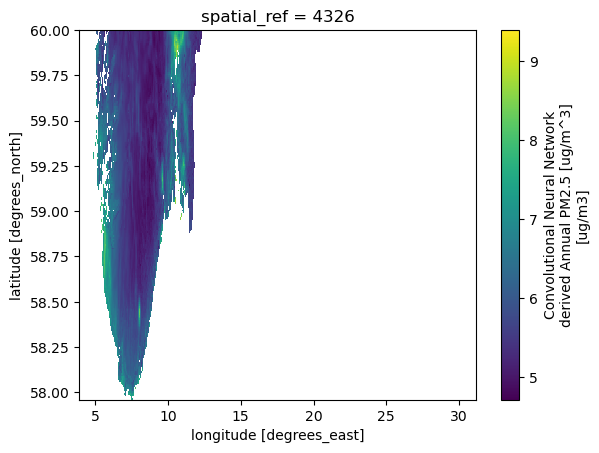

In [22]:
#https://sites.wustl.edu/acag/surface-pm2-5/#V6.GL.02.04
pm25_ds = xr.open_dataset("../../data/raw/SatPM2.5/V6GL02.04.CNNPM25.EU.201801-201812.nc", chunks = "auto")
pm25_ds = pm25_ds.odc.assign_crs("EPSG:4326")
pm25_norway_da = pm25_ds.odc.crop(geom_to_odcgeom(norway_bounds.geometry.values[0])).compute().PM25
pm25_norway_da.plot.imshow()
# => The SatPM2.5 data does not extend to the north of Norway
del pm25_norway_da

## Alternative PM2.5 Dataset
Load and visualize PM2.5 data from the GHAP dataset for improved coverage.

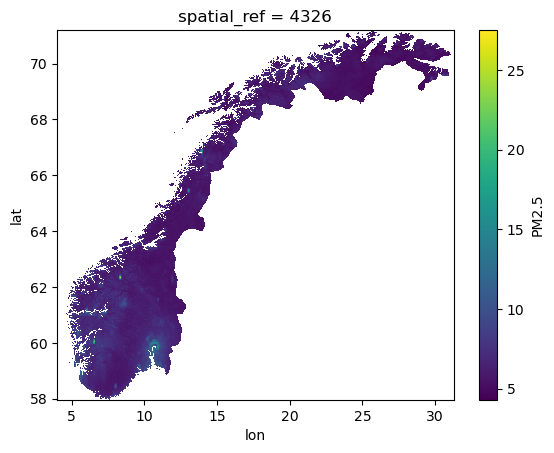

In [ ]:
#https://zenodo.org/records/10800980
pm25_ds = xr.open_dataset("../../data/raw/GHAP/GHAP_PM2.5_Y1K_2018_V1.nc", chunks = "auto")
pm25_ds = pm25_ds.odc.assign_crs("EPSG:4326")
pm25_norway_da = pm25_ds.odc.crop(geom_to_odcgeom(norway_bounds.geometry.values[0])).compute()["PM2.5"]
pm25_norway_da.drop_attrs().plot.imshow()
